In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [18]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../../../Data/paths_AOA_trainData.csv')
df_test = pd.read_csv('../../../Data/paths_AOA_testData.csv')


In [19]:

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','emp', 'educ','liv','justice', 'sexorient', 'co']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['new','svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_AOA_timepoint_pre_cols = ['svc_AOA_op_7days_pre', 'svc_AOA_op_30days_pre', 'svc_AOA_op_60days_pre', 'svc_AOA_op_90days_pre',
                     'svc_AOA_es_7days_pre', 'svc_AOA_es_30days_pre', 'svc_AOA_es_60days_pre', 'svc_AOA_es_90days_pre',
                     'svc_AOA_24h_7days_pre', 'svc_AOA_24h_30days_pre', 'svc_AOA_24h_60days_pre', 'svc_AOA_24h_90days_pre',
                     'svc_AOA_ip_7days_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'svc_AOA_ip_90days_pre']

output_col = ['svc_AOA_ip_7days_postdc_bi']

drop_cols = ['']

In [20]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_AOA_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_Age 60+':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['co', 'substance', 'justice']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre_sub', 'svc_AOA_es_7days_pre', 'svc_AOA_es_30days_pre', 'svc_AOA_es_60days_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'as_loc_IPFFS', 'as_loc_IPLIHP', 'as_close_Medical Hospital', 'as_close_Psychiatric Hospital', 'as_close_Required Lower Level\r\nof Care', 'loc1_pre_None']

In [21]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [22]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [23]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [24]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [28]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [13]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:02.276005
done
knn... Time elapsed  0:57:59.447918
done
logistic... Time elapsed  0:00:24.378526
done
mlp-nn... Time elapsed  0:06:30.810573
done
decision tree... Time elapsed  0:00:47.464827
done
random forest... Time elapsed  0:03:21.861930
done
gbm... Time elapsed  0:14:42.711708
done
Done.

Accuracy : 0.4298
Precision : 0.3997
Recall : 0.9539
F1 score : 0.5634
AUC score : 0.5472
AUC score : 0.4105

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.10      0.18     12883
           1       0.40      0.95      0.56      8087

    accuracy                           0.43     20970
   macro avg       0.59      0.53      0.37     20970
weighted avg       0.63      0.43      0.33     20970


Confusion matrix : 
 [[ 1299 11584]
 [  373  7714]]
done.

Accuracy : 0.6160
Precision : 0.5016
Recall : 0.6658
F1 score : 0.5722
AUC score : 0.6607
AUC score : 0.5036

Classification report

(0.7271340009537435,
 0.6674217754495257,
 0.5829108445653518,
 0.6223102310231023,
 0.7865097642198762,
 0.7145135412021015)

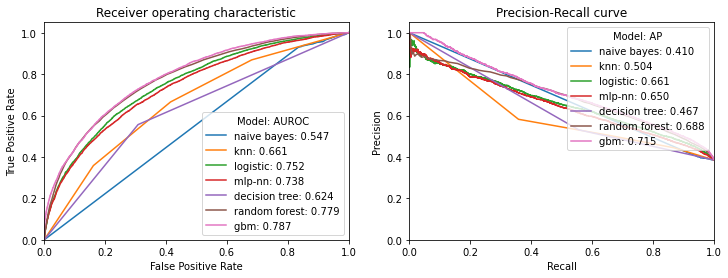

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [17]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
IP_history                            6.530643
svc_AOA_ip_90days_pre                 2.631904
svc_AOA_es_90days_pre                 1.981405
as_close_State Hospital               1.784785
loc5_pre_PREV                         1.448236
loc5_pre_CM                           1.425082
loc4_pre_TBS                          1.369317
loc2_pre_LTC                          1.367774
loc3_pre_LTCINST                      1.222803
as_close_Psychiatric Hospital         1.141236
loc3_pre_LTC                          1.048387
svc_AOA_ip_30days_pre                 1.009089
as_close_Transfer Medical Hospital    0.990836
loc3_pre_BHC                          0.988520
loc5_pre_IPCAPS                       0.936419
Name: LR, dtype: float64


In [18]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
IP_history                        0.207297
as_length_IP                      0.090383
svc_AOA_ip_90days_pre             0.070025
age                               0.060289
svc_pre_all                       0.046108
as_gap_since_former_IP            0.044371
svc_pre                           0.027899
svc_AOA_es_90days_pre             0.015533
svc_AOA_op_90days_pre             0.013636
sexorient_Missing/Not Reported    0.012134
svc_AOA_es_7days_pre              0.011974
svc_AOA_op_60days_pre             0.011959
svc_AOA_op_30days_pre             0.010612
svc_AOA_es_60days_pre             0.010505
svc_AOA_es_30days_pre             0.009895
Name: DT, dtype: float64


In [19]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
IP_history                        0.066757
as_length_IP                      0.066082
as_gap_since_former_IP            0.051334
svc_pre_all                       0.046903
age                               0.046521
svc_AOA_ip_90days_pre             0.033827
svc_pre                           0.032986
svc_AOA_ip_60days_pre             0.026915
svc_AOA_es_90days_pre             0.023104
svc_AOA_op_90days_pre             0.021120
svc_AOA_op_60days_pre             0.019234
svc_AOA_es_60days_pre             0.019201
svc_AOA_ip_30days_pre             0.017228
svc_AOA_op_30days_pre             0.016899
sexorient_Missing/Not Reported    0.016207
Name: RF, dtype: float64


In [20]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
IP_history                                              0.395709
svc_AOA_ip_90days_pre                                   0.162719
as_length_IP                                            0.128191
sexorient_Missing/Not Reported                          0.045456
liv_Lives Independently                                 0.021668
svc_pre_sub                                             0.020817
svc_AOA_ip_60days_pre                                   0.019352
as_close_IMD/MHRC                                       0.017254
svc_AOA_ip_30days_pre                                   0.016652
dx_group_Schizophrenia and Other Psychotic Disorders    0.016238
as_close_Home/Shelter/Self                              0.016104
gender_Male                                             0.013632
dx_group_Depressive Disorders                           0.013258
substance                                               0.010847
as_gap_since_former_IP                                  0.009472
Name: GBM

In [21]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,IP_history,6.530643,0.207297,0.066757,0.395709,0.223254
1,as_length_IP,-2.678474,0.090383,0.066082,0.128191,0.094886
2,svc_AOA_ip_90days_pre,2.631904,0.070025,0.033827,0.162719,0.088857
3,age,-0.465221,0.060289,0.046521,0.001215,0.036009
4,as_gap_since_former_IP,-0.608525,0.044371,0.051334,0.009472,0.035059
5,svc_pre_all,-1.489098,0.046108,0.046903,0.000446,0.031152
6,sexorient_Missing/Not Reported,-0.385935,0.012134,0.016207,0.045456,0.024599
7,svc_pre,-0.987836,0.027899,0.032986,0.000235,0.020373
8,svc_AOA_ip_60days_pre,-0.151136,0.002447,0.026915,0.019352,0.016238
9,svc_AOA_es_90days_pre,1.981405,0.015533,0.023104,0.007678,0.015438


In [22]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['IP_history',
 'as_length_IP',
 'svc_AOA_ip_90days_pre',
 'age',
 'as_gap_since_former_IP',
 'svc_pre_all',
 'sexorient_Missing/Not Reported',
 'svc_pre',
 'svc_AOA_ip_60days_pre',
 'svc_AOA_es_90days_pre',
 'liv_Lives Independently',
 'svc_pre_sub',
 'svc_AOA_ip_30days_pre',
 'as_close_Home/Shelter/Self',
 'dx_group_Schizophrenia and Other Psychotic Disorders']

### Fit Boruta-select variables into the models

In [23]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.183999
done
knn... Time elapsed  0:00:54.991995
done
logistic... Time elapsed  0:00:01.025000
done
mlp-nn... Time elapsed  0:01:17.914004
done
decision tree... Time elapsed  0:00:03.047009
done
random forest... Time elapsed  0:00:55.679001
done
gbm... Time elapsed  0:00:54.873997
done
Done.

Accuracy : 0.5996
Precision : 0.4882
Recall : 0.7903
F1 score : 0.6035
AUC score : 0.7097
AP score : 0.6146

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.48      0.60     12883
           1       0.49      0.79      0.60      8087

    accuracy                           0.60     20970
   macro avg       0.64      0.64      0.60     20970
weighted avg       0.67      0.60      0.60     20970


Confusion matrix : 
 [[6182 6701]
 [1696 6391]]
done.

Accuracy : 0.6459
Precision : 0.5367
Recall : 0.5976
F1 score : 0.5655
AUC score : 0.6741
AP score : 0.5210

Classification report : 
  

(0.713447782546495,
 0.6265221626887482,
 0.6362062569556077,
 0.6313270752806921,
 0.778107071854546,
 0.7034120356967164)

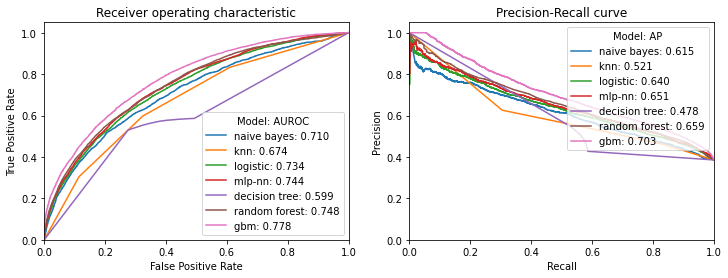

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [37]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_AOA_ip_7days_postdc_bi']


In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [39]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [41]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.167999
done
knn... Time elapsed  0:00:38.527011
done
logistic... Time elapsed  0:00:01.138986
done
mlp-nn... Time elapsed  0:08:38.920001
done
decision tree... Time elapsed  0:00:04.196010
done
random forest... Time elapsed  0:00:59.501000
done
gbm... Time elapsed  0:01:03.635000
done
Done.

Accuracy : 0.6789
Precision : 0.5999
Recall : 0.5027
F1 score : 0.5470
AUC score : 0.7058
AP score : 0.6089

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     12883
           1       0.60      0.50      0.55      8087

    accuracy                           0.68     20970
   macro avg       0.66      0.65      0.65     20970
weighted avg       0.67      0.68      0.67     20970


Confusion matrix : 
 [[10172  2711]
 [ 4022  4065]]
done.

Accuracy : 0.6254
Precision : 0.5127
Recall : 0.5782
F1 score : 0.5435
AUC score : 0.6481
AP score : 0.4967

Classification report :

(0.5327134000953744,
 0.4474717722140403,
 0.901694076913565,
 0.5981216421277119,
 0.7105524661793102,
 0.6237255539071868)

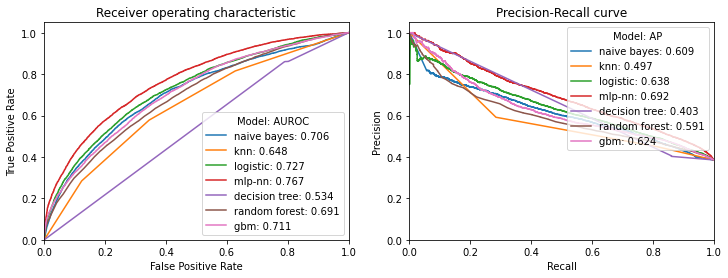

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [13]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='roc_auc',n_jobs=-1, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='roc_auc')

In [14]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 1, 'n_estimators': 1500}, 0.9243163173884821)

In [15]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=1,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='roc_auc',n_jobs=-1, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

({'max_depth': 4}, 0.9243163173884821)

In [25]:
new=GradientBoostingClassifier(learning_rate=1, n_estimators=1500, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(learning_rate=1, max_depth=4, max_features='sqrt',
                           n_estimators=1500, random_state=300, subsample=1)

In [26]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.8734
Precision : 0.5583
Recall : 0.2909
F1 score : 0.3825
AUC score : 0.6439
AP score : 0.3958

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     18155
           1       0.56      0.29      0.38      2829

    accuracy                           0.87     20984
   macro avg       0.73      0.63      0.66     20984
weighted avg       0.85      0.87      0.86     20984


Confusion matrix : 
 [[17504   651]
 [ 2006   823]]


as_length_IP                                0.474121
IP_history                                  0.200735
svc_pre_all                                 0.076963
svc_AOA_es_60days_pre                       0.057726
as_close_Psychiatric Hospital               0.046990
svc_AOA_ip_60days_pre                       0.029972
svc_AOA_es_7days_pre                        0.025371
svc_AOA_es_30days_pre                       0.022923
svc_AOA_ip_30days_pre                       0.018002
as_close_Medical Hospital                   0.011446
as_loc_IPLIHP                               0.009981
svc_pre_sub                                 0.008018
as_close_Required Lower Level\r\nof Care    0.007456
as_loc_IPFFS                                0.005374
loc1_pre_None                               0.004924
dtype: float64


Text(0, 0.5, 'Feature Importance Score')

C:\Users\Anh Tran\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anh Tran\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


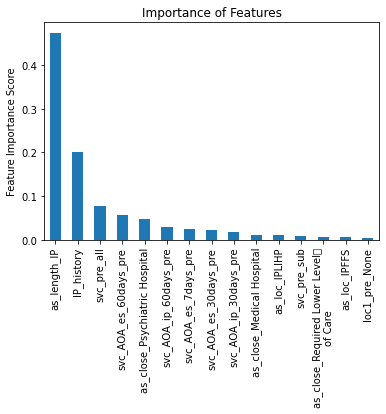

In [27]:
predictors=Xtrainb.columns
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [29]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances)

Fitting models.
logistic... Time elapsed  0:00:01.672007
done
Done.

as_length_IP                               -9.343145
IP_history                                  3.521905
svc_pre_all                                -2.707684
svc_pre_sub                                -0.395574
svc_AOA_es_7days_pre                       -0.024442
svc_AOA_es_30days_pre                       1.433315
svc_AOA_es_60days_pre                       0.409765
svc_AOA_ip_30days_pre                       2.840713
svc_AOA_ip_60days_pre                       1.761642
as_loc_IPFFS                                0.153473
as_loc_IPLIHP                              -0.231218
as_close_Medical Hospital                   1.962402
as_close_Psychiatric Hospital               2.733156
as_close_Required Lower Level\r\nof Care    1.129265
loc1_pre_None                              -0.143597
Name: LR, dtype: float64


max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [ ]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

In [ ]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

In [ ]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

In [ ]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

In [ ]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''